![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

# Predicting the stability regime of rising bubbles

In this notebook, we cover the following topics:

1. Forces acting on a rising bubbles
2. Loading, inspecting, and preparing the data
3. Binary classification
4. Extension to multiple classes

In [39]:
from typing import List, Tuple
import pandas as pd
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# make results reproducible
pt.manual_seed(0)

# increase plot resolution
plt.rcParams["figure.dpi"] = 160

# create output directory
output = "output"
!mkdir -p $output

## Forces acting on a rising bubble

<video controls height="800" src="./media/b8_mesh_plic.ogv"></video>

## Loading, inspecting, and preparing the data

In [40]:
data_path = "../datasets/path_shape_regimes/"
regimes = ["I", "II", "III", "IV", "V"]
raw_data_files = [f"regime_{regime}.csv" for regime in regimes]
files = [pd.read_csv(data_path + file_name, header=0, names=["Ga", "Eo"]) for file_name in raw_data_files]
for data, regime in zip(files, regimes):
    data["regime"] = regime
data = pd.concat(files, ignore_index=True)
data.sample(5)

,Ga,Eo,regime
55,22.6060,40.557,III
75,50.0910,39.896,V
48,6.9836,51.882,III
102,518.2900,19.694,V
65,101.0630,19.373,IV


In [41]:
data.describe()

,Ga,Eo
count,103.000000,103.000000
mean,122.638672,37.759512
std,149.717655,58.145646
min,6.939000,0.099640
25%,22.600500,1.000500
50%,60.116000,10.046000
75%,186.545000,48.188500
max,518.290000,212.910000


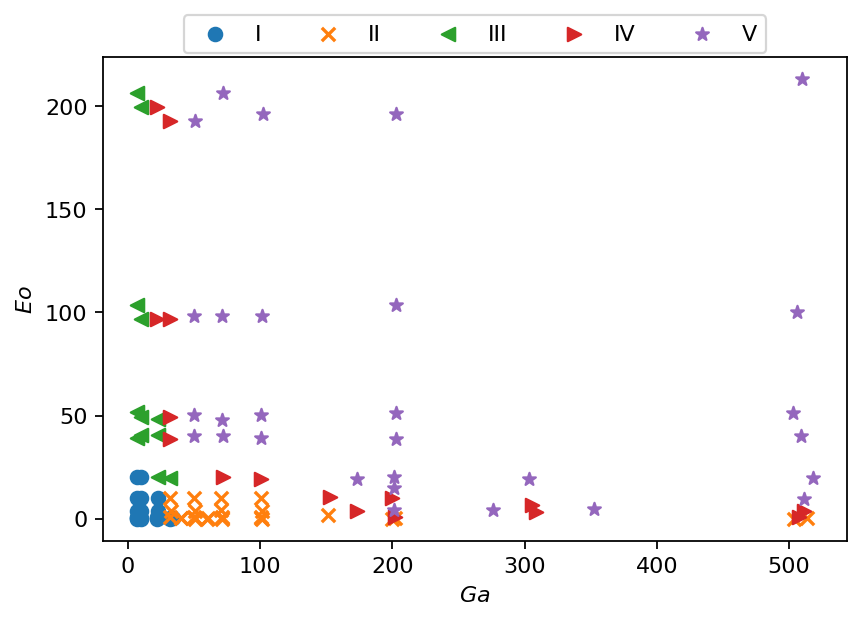

In [42]:
markers = ["o", "x", "<", ">", "*"]
for regime, marker in zip(regimes, markers):
    plt.scatter(data[data["regime"] == regime].Ga, data[data["regime"] == regime].Eo,
                marker=marker, label=regime)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.11), ncol=5)
plt.xlabel(r"$Ga$")
plt.ylabel(r"$Eo$")
plt.savefig(f"{output}/ga_eo_data_raw.svg", bbox_inches="tight")

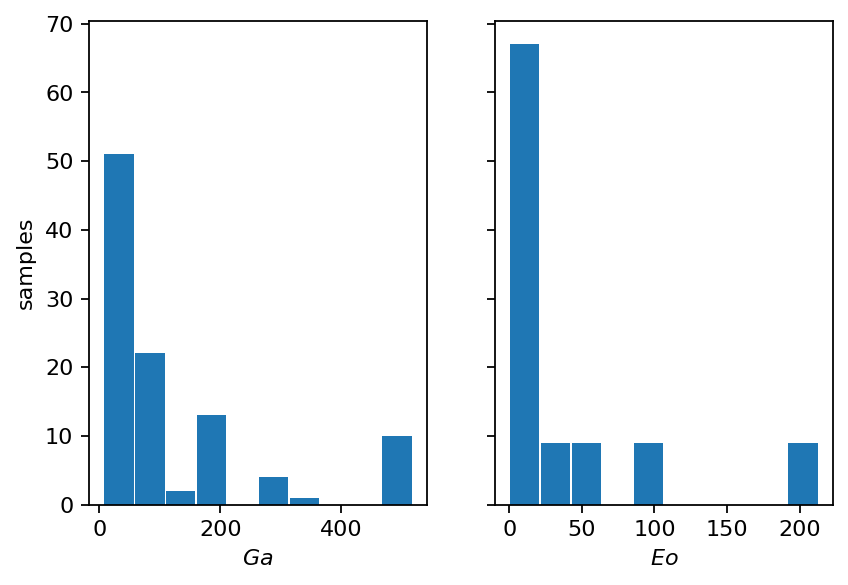

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(data.Ga, rwidth=0.95)
ax1.set_xlabel(r"$Ga$")
ax1.set_ylabel(r"samples")
ax2.hist(data.Eo, rwidth=0.95)
ax2.set_xlabel(r"$Eo$")
plt.savefig(f"{output}/ga_eo_raw_histogram.svg", bbox_inches="tight")

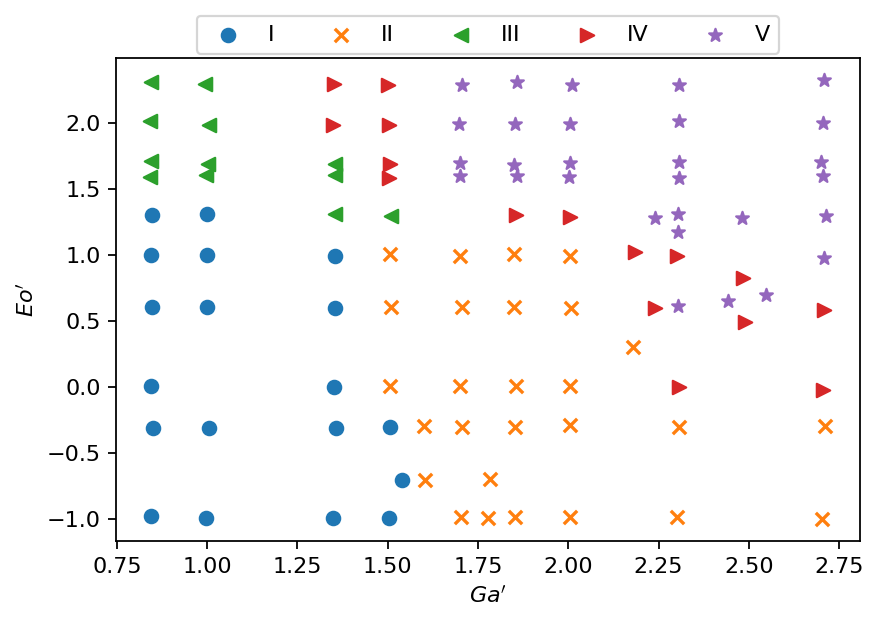

In [44]:
logData = data[["Ga", "Eo"]].apply(np.log10)
logData["regime"] = data["regime"].copy()

for regime, marker in zip(regimes, markers):
    plt.scatter(logData[logData["regime"] == regime].Ga, logData[logData["regime"] == regime].Eo,
                marker=marker, label=regime)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.11), ncol=5)
plt.xlabel(r"$Ga^\prime$")
plt.ylabel(r"$Eo^\prime$")
plt.savefig(f"{output}/ga_eo_log.svg", bbox_inches="tight")

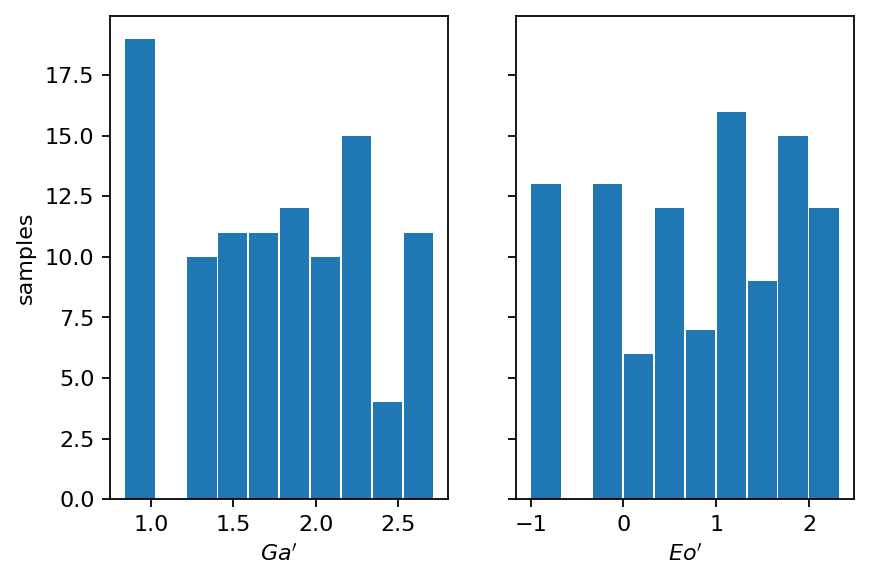

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(logData.Ga, rwidth=0.95)
ax1.set_xlabel(r"$Ga^\prime$")
ax1.set_ylabel(r"samples")
ax2.hist(logData.Eo, rwidth=0.95)
ax2.set_xlabel(r"$Eo^\prime$")
plt.savefig(f"{output}/ga_eo_log_histogram.svg", bbox_inches="tight")

## Binary classification

### Manual binary classification

In [46]:
def weighted_sum(logGa: pt.Tensor, logEo: pt.Tensor, p: pt.Tensor) -> pt.Tensor:
    """Compute the weighted sum of log(Ga), log(Eo), and bias.

    :param logGa: common logarithm of Galilei number
    :type logGa: pt.Tensor
    :param logEo: common logarithm of Eötvös number
    :type logEo: pt.Tensor
    :param p: weight parameter
    :type p: pt.Tensor
    :return: weighted sum of log(Ga), log(Eo), and bias
    :rtype: pt.Tensor
    """
    n_samples = logGa.shape[0]
    features = pt.vstack((logGa, logEo, pt.ones(n_samples))).T
    return features.mv(p)

In [47]:
def add_markers(ax, regime_ind):
    for i in regime_ind:
        ax.scatter(logData[logData["regime"] == regimes[i]].Ga, logData[logData["regime"] == regimes[i]].Eo,
                   marker=markers[i], s=10, lw=1, c=f"C{i}", alpha=0.5) 

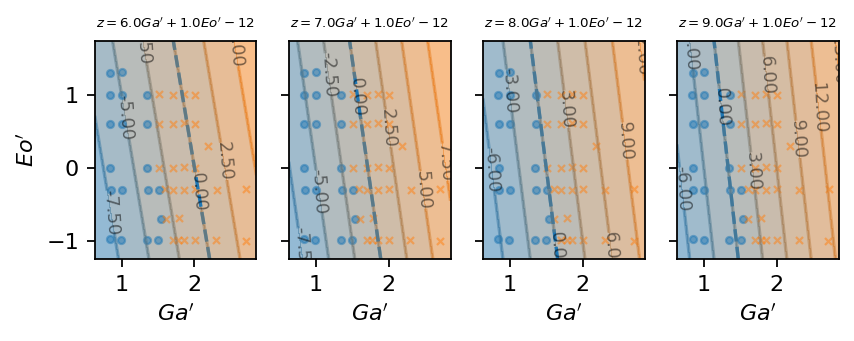

In [48]:
xx, yy = pt.meshgrid(
    pt.linspace(logData.Ga.min()*0.75, logData.Ga.max()*1.05, 500),
    pt.linspace(logData.Eo.min()*1.25, logData.Eo.max()*0.75, 500)
)
cm = LinearSegmentedColormap.from_list("blue_to_orange", ['C0', 'C1'], 20)
fig, axarr = plt.subplots(1, 4, sharex=True, sharey=True)

for i, w in enumerate(pt.linspace(6, 9, 4)):
    weighted_inputs = weighted_sum(xx.flatten(), yy.flatten(), pt.tensor([w, 1.0, -12.0]))
    axarr[i].contourf(xx, yy, weighted_inputs.reshape(xx.shape), cmap=cm, alpha=0.5)
    axarr[i].contour(xx, yy, weighted_inputs.reshape(xx.shape), levels=(0,), cmap=cm, linestyles="--", )
    cont = axarr[i].contour(xx, yy, weighted_inputs.reshape(xx.shape), cmap=cm, alpha=0.5)
    axarr[i].clabel(cont, fontsize=8, colors="k", fmt=lambda x: f"{x:2.2f}", inline_spacing=20,  zorder=6)
    axarr[i].set_aspect("equal")
    axarr[i].set_xlabel(r"$Ga^\prime$")
    axarr[i].set_title(r"$z={:1.1f}Ga^\prime + 1.0Eo^\prime -12$".format(w), fontsize=6)
    add_markers(axarr[i], (0, 1))
axarr[0].set_ylabel(r"$Eo^\prime$")
plt.savefig(f"{output}/weighted_sum_ga_var.svg", bbox_inches="tight")

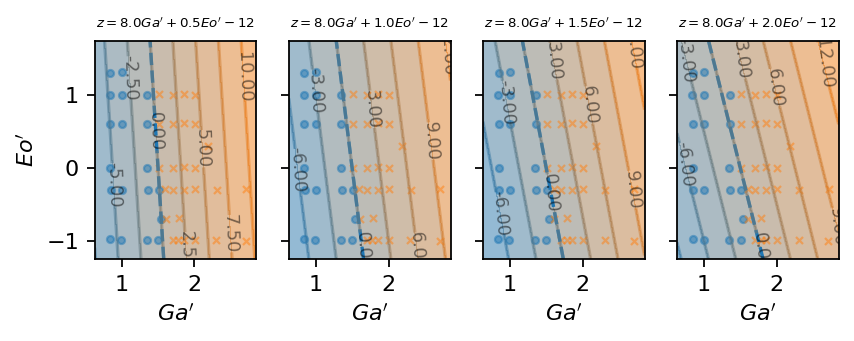

In [49]:
fig, axarr = plt.subplots(1, 4, sharex=True, sharey=True)

for i, w in enumerate(pt.linspace(0.5, 2.0, 4)):
    weighted_inputs = weighted_sum(xx.flatten(), yy.flatten(), pt.tensor([8.0, w, -12.0]))
    axarr[i].contourf(xx, yy, weighted_inputs.reshape(xx.shape), cmap=cm, alpha=0.5)
    axarr[i].contour(xx, yy, weighted_inputs.reshape(xx.shape), levels=(0,), cmap=cm, linestyles="--", )
    cont = axarr[i].contour(xx, yy, weighted_inputs.reshape(xx.shape), cmap=cm, alpha=0.5)
    axarr[i].clabel(cont, fontsize=8, colors="k", fmt=lambda x: f"{x:2.2f}", inline_spacing=20,  zorder=6)
    axarr[i].set_aspect("equal")
    axarr[i].set_xlabel(r"$Ga^\prime$")
    axarr[i].set_title(r"$z=8.0Ga^\prime + {:1.1f}Eo^\prime - 12$".format(w), fontsize=6)
    add_markers(axarr[i], (0, 1))
axarr[0].set_ylabel(r"$Eo^\prime$")
plt.savefig(f"{output}/weighted_sum_eo_var.svg", bbox_inches="tight")

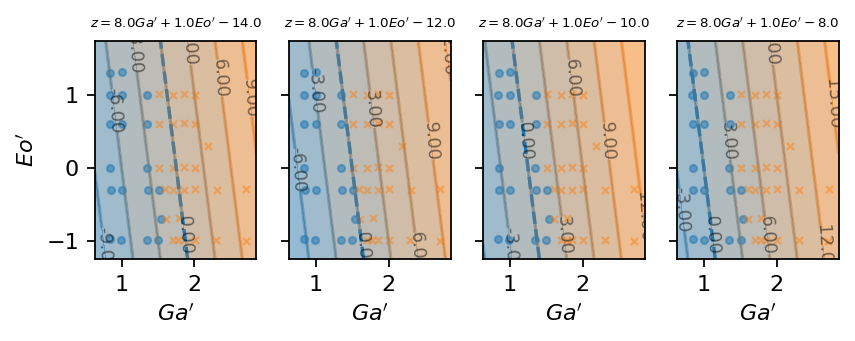

In [50]:
fig, axarr = plt.subplots(1, 4, sharex=True, sharey=True)

for i, w in enumerate(pt.linspace(-14, -8, 4)):
    weighted_inputs = weighted_sum(xx.flatten(), yy.flatten(), pt.tensor([8.0, 1.0, w]))
    axarr[i].contourf(xx, yy, weighted_inputs.reshape(xx.shape), cmap=cm, alpha=0.5)
    axarr[i].contour(xx, yy, weighted_inputs.reshape(xx.shape), levels=(0,), cmap=cm, linestyles="--", )
    cont = axarr[i].contour(xx, yy, weighted_inputs.reshape(xx.shape), cmap=cm, alpha=0.5)
    axarr[i].clabel(cont, fontsize=8, colors="k", fmt=lambda x: f"{x:2.2f}", inline_spacing=20,  zorder=6)
    axarr[i].set_aspect("equal")
    axarr[i].set_xlabel(r"$Ga^\prime$")
    axarr[i].set_title(r"$z=8.0Ga^\prime + 1.0Eo^\prime {:+1.1f}$".format(w), fontsize=6)
    add_markers(axarr[i], (0, 1))
axarr[0].set_ylabel(r"$Eo^\prime$")
plt.savefig(f"{output}/weighted_sum_bias_var.svg", bbox_inches="tight")

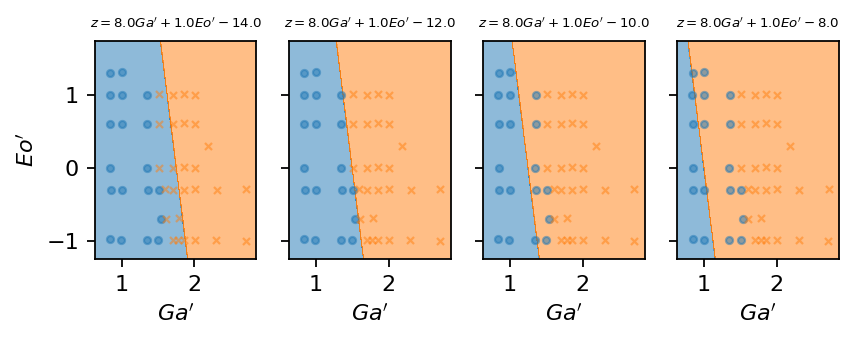

In [51]:
fig, axarr = plt.subplots(1, 4, sharex=True, sharey=True)

for i, w in enumerate(pt.linspace(-14, -8, 4)):
    weighted_inputs = weighted_sum(xx.flatten(), yy.flatten(), pt.tensor([8.0, 1.0, w]))
    prediction = pt.heaviside(weighted_inputs, pt.tensor(0.0))
    axarr[i].contourf(xx, yy, prediction.reshape(xx.shape), cmap=ListedColormap(['C0', 'C1']), alpha=0.5)
    axarr[i].set_aspect("equal")
    axarr[i].set_xlabel(r"$Ga^\prime$")
    axarr[i].set_title(r"$z=8.0Ga^\prime + 1.0Eo^\prime {:+1.1f}$".format(w), fontsize=6)
    add_markers(axarr[i], (0, 1))
axarr[0].set_ylabel(r"$Eo^\prime$")
plt.savefig(f"{output}/heaviside_prediction.svg", bbox_inches="tight")

In [52]:
class Perceptron(object):
    """Implements perceptron algorithm and learning rule.
    """
    def __init__(self, n_weights: int):
        """Initialize perceptron instance.

        :param n_weights: number of free parameters; must be
            equal to the number of features
        :type n_weights: int
        """
        self._p = pt.rand(n_weights)*2.0 - 1.0

    def _loss(self, X: pt.Tensor, y: pt.Tensor) -> pt.Tensor:
        return 0.5 * pt.sum((y - self.predict(X))**2)

    def _loss_gradient(self, X: pt.Tensor, y: pt.Tensor) -> pt.Tensor:
        delta = y - self.predict(X)
        return -pt.cat((X, pt.ones(X.shape[0]).unsqueeze(-1)), dim=-1).T.mv(delta)

    def train(self, X: pt.Tensor, y: pt.Tensor, epochs: int=500,
              lr: float=0.01, tol: float=1.0e-6) -> List[float]:
        loss = []
        for e in range(epochs):
            self._p -= lr*self._loss_gradient(X, y)
            loss.append(self._loss(X, y).item())
            if loss[-1] < tol:
                print(f"Converged after {e+1} epochs.")
                return loss
        print(f"Training did not converge within {epochs} epochs")
        print(f"Final loss: {loss[-1]:2.3f}")
        return loss

    def predict(self, X: pt.Tensor):
        """Make binary prediction.

        :param X: feature tensor; the first dimension is assumed
            to be the batch dimension
        :type X: pt.Tensor
        """
        weighted_sum = X.mv(self._p[:-1]) + self._p[-1]
        return pt.heaviside(weighted_sum, pt.tensor(0.0))

In [53]:
one_two = (logData.regime == "I") | (logData.regime == "II")
features = pt.tensor(logData[one_two][["Ga", "Eo"]].values).type(pt.float32)
logData["ordinal"] = 0.0
for i, r in enumerate(regimes):
    logData.ordinal.mask(logData.regime == r, float(i), inplace=True)
label = pt.tensor(logData.ordinal[one_two].values).type(pt.float32)

In [54]:
perceptron = Perceptron(3)
loss = perceptron.train(features, label)
p = perceptron._p
print(f"Final equations: z={p[0]:2.3f}Ga'{p[1]:+2.3f}Eo'{p[2]:+2.3f}")

Converged after 30 epochs.
Final equations: z=0.520Ga'+0.046Eo'-0.783


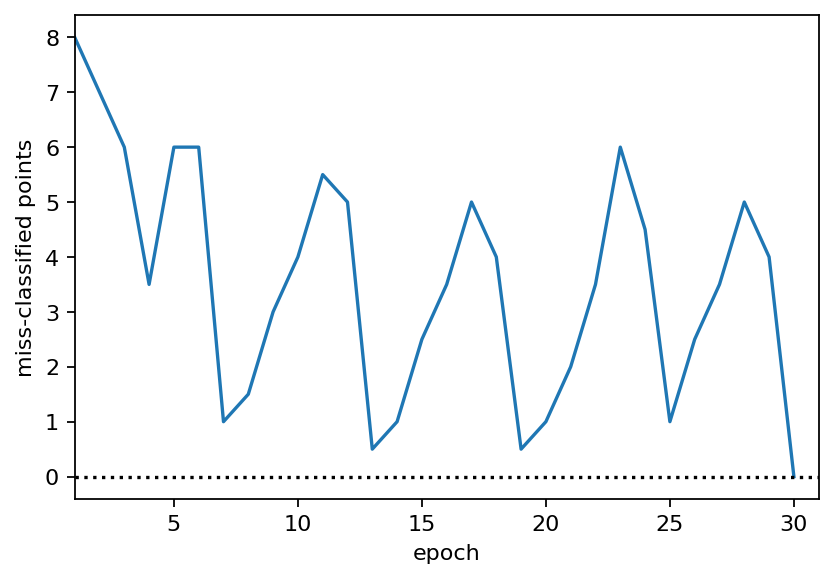

In [55]:
plt.plot(range(1, len(loss)+1), loss)
plt.xlabel("epoch")
plt.ylabel("miss-classified points")
plt.xlim(1.0, len(loss)+1)
plt.axhline(0.0, 0.0, 1.0, ls=":", c="k")
plt.savefig(f"{output}/perceptron_loss.svg", bbox_inches="tight")

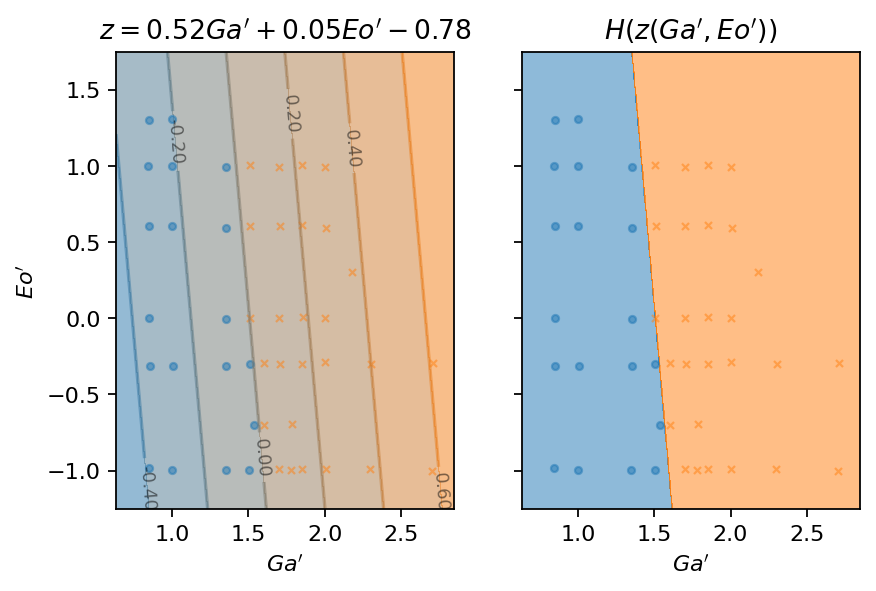

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

weighted_inputs = weighted_sum(xx.flatten(), yy.flatten(), perceptron._p)
prediction = perceptron.predict(pt.stack((xx.flatten(), yy.flatten())).T)
ax1.contourf(xx, yy, weighted_inputs.reshape(xx.shape), cmap=cm, alpha=0.5)
cont = ax1.contour(xx, yy, weighted_inputs.reshape(xx.shape), cmap=cm, alpha=0.5)
ax1.clabel(cont, fontsize=8, colors="k", fmt=lambda x: f"{x:2.2f}", inline_spacing=5,  zorder=6)
ax2.contourf(xx, yy, prediction.reshape(xx.shape), cmap=ListedColormap(['C0', 'C1']), alpha=0.5)
for ax in (ax1, ax2):
    ax.set_aspect("equal")
    ax.set_xlabel(r"$Ga^\prime$")
    add_markers(ax, (0, 1))
ax1.set_ylabel(r"$Eo^\prime$")
ax1.set_title(r"$z={:1.2f}Ga^\prime {:+1.2f}Eo^\prime {:+1.2f}$".format(*perceptron._p))
ax2.set_title(r"$H(z(Ga^\prime , Eo^\prime))$")
plt.savefig(f"{output}/perceptron_prediction.svg", bbox_inches="tight")

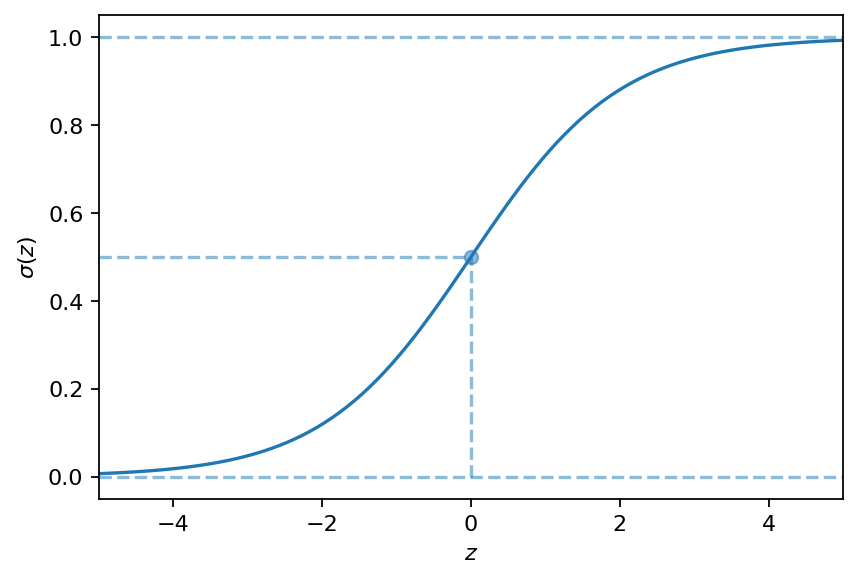

In [57]:
z = pt.linspace(-5, 5, 100)
plt.plot(z, pt.sigmoid(z))
plt.scatter([0.0], [0.5], marker="o", alpha=0.5)
plt.vlines(0.0, 0.0, 0.5, "C0", "--", alpha=0.5)
plt.hlines([0.0, 0.5, 1.0], [-5, -5, -5], [5, 0, 5], "C0", "--", alpha=0.5)
plt.xlim(-5, 5)
plt.ylim(-0.05, 1.05)
plt.xlabel(r"$z$")
plt.ylabel(r"$\sigma (z)$")
plt.savefig(f"{output}/sigmoid_prob.svg", bbox_inches="tight")

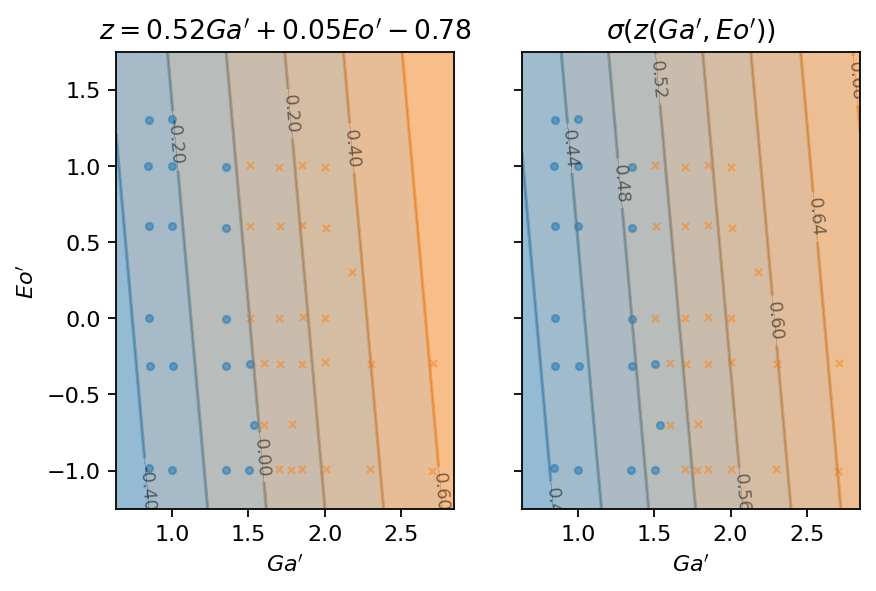

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

weighted_inputs = weighted_sum(xx.flatten(), yy.flatten(), perceptron._p)
probs = pt.sigmoid(weighted_inputs)
ax1.contourf(xx, yy, weighted_inputs.reshape(xx.shape), cmap=cm, alpha=0.5)
cont = ax1.contour(xx, yy, weighted_inputs.reshape(xx.shape), cmap=cm, alpha=0.5)
ax1.clabel(cont, fontsize=8, colors="k", fmt=lambda x: f"{x:2.2f}", inline_spacing=5,  zorder=6)
ax2.contourf(xx, yy, probs.reshape(xx.shape), cmap=cm, alpha=0.5)
cont = ax2.contour(xx, yy, probs.reshape(xx.shape), cmap=cm, alpha=0.5)
ax2.clabel(cont, fontsize=8, colors="k", fmt=lambda x: f"{x:2.2f}", inline_spacing=5,  zorder=6)
for ax in (ax1, ax2):
    ax.set_aspect("equal")
    ax.set_xlabel(r"$Ga^\prime$")
    add_markers(ax, (0, 1))
ax1.set_ylabel(r"$Eo^\prime$")
ax1.set_title(r"$z={:1.2f}Ga^\prime {:+1.2f}Eo^\prime {:+1.2f}$".format(*perceptron._p))
ax2.set_title(r"$\sigma(z(Ga^\prime , Eo^\prime))$")
plt.savefig(f"{output}/binary_proabilities.svg", bbox_inches="tight")

In [59]:
class LogisticRegression(object):
    """Implementation of logistic regresion.
    """
    def __init__(self, n_weights):
        self._p = pt.rand(n_weights)*2.0 - 1.0

    def _joint_probability(self, X: pt.Tensor, y: pt.Tensor) -> pt.Tensor:
        probs = self.probability(X)
        joint = pt.pow(probs, y) * pt.pow(1.0-probs, 1-y)
        return pt.prod(joint)

    def _loss(self, X: pt.Tensor, y: pt.Tensor) -> pt.Tensor:
        probs = self.probability(X)
        entropy = y*pt.log(probs+1.0e-6) + (1-y)*pt.log(1.0-probs+1.0e-6)
        return -entropy.mean()

    def _loss_gradient(self, X: pt.Tensor, y: pt.Tensor) -> pt.Tensor:
        delta = y - self.probability(X)
        grad = pt.cat((X, pt.ones(X.shape[0]).unsqueeze(-1)), dim=-1) * delta.unsqueeze(-1)
        return -grad.mean(dim=0)

    def train(self, X: pt.Tensor, y: pt.Tensor, epochs: int=10000,
              lr: float=1.0, tol: float=0.1) -> List[float]:
        loss = []
        for e in range(epochs):
            self._p -= lr*self._loss_gradient(X, y)
            loss.append(self._loss(X, y).item())
            if loss[-1] < tol:
                print(f"Converged after {e+1} epochs.")
                return loss
        print(f"Training did not converge within {epochs} epochs")
        print(f"Final loss: {loss[-1]:2.3f}")
        return loss

    def probability(self, X: pt.Tensor) -> pt.Tensor:
        weighted_sum = X.mv(self._p[:-1]) + self._p[-1]
        return pt.sigmoid(weighted_sum)

    def predict(self, X: pt.Tensor) -> pt.Tensor:
        return pt.heaviside(self.probability(X)-0.5, pt.tensor(0.0))



In [60]:
log_regressor = LogisticRegression(3)
loss = log_regressor.train(features, label, lr=0.5)
p = log_regressor._p
print(f"Weighted sum: z={p[0]:2.3f}Ga'{p[1]:+2.3f}Eo'{p[2]:+2.3f}")

Converged after 6066 epochs.
Weighted sum: z=14.354Ga'+1.352Eo'-21.390


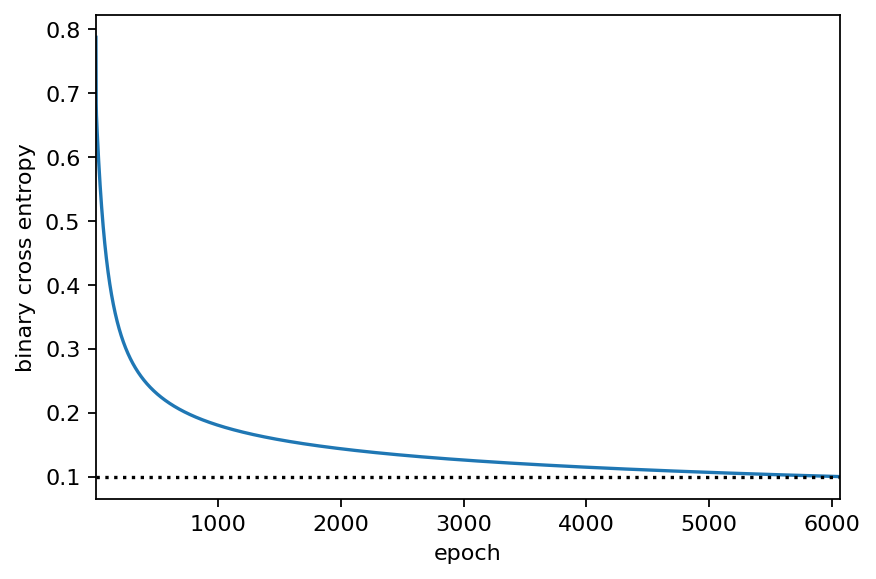

In [61]:
plt.plot(range(1, len(loss)+1), loss)
plt.xlabel("epoch")
plt.ylabel("binary cross entropy")
plt.xlim(1.0, len(loss)+1)
plt.axhline(0.1, 0.0, 1.0, ls=":", c="k")
plt.savefig(f"{output}/log_regression_loss.svg", bbox_inches="tight")

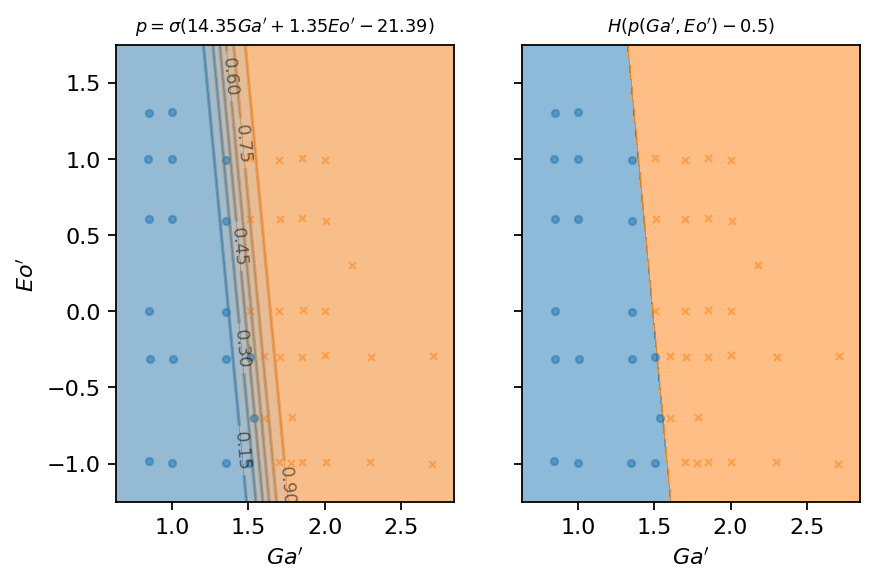

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

probs = log_regressor.probability(pt.stack((xx.flatten(), yy.flatten())).T)
prediction = log_regressor.predict(pt.stack((xx.flatten(), yy.flatten())).T)
ax1.contourf(xx, yy, probs.reshape(xx.shape), cmap=cm, alpha=0.5)
cont = ax1.contour(xx, yy, probs.reshape(xx.shape), cmap=cm, alpha=0.5)
ax1.clabel(cont, fontsize=8, colors="k", fmt=lambda x: f"{x:2.2f}", inline_spacing=5,  zorder=6)
ax2.contourf(xx, yy, prediction.reshape(xx.shape), cmap=ListedColormap(['C0', 'C1']), alpha=0.5)
for ax in (ax1, ax2):
    ax.set_aspect("equal")
    ax.set_xlabel(r"$Ga^\prime$")
    add_markers(ax, (0, 1))
ax1.set_ylabel(r"$Eo^\prime$")
ax1.set_title(r"$p=\sigma({:1.2f}Ga^\prime {:+1.2f}Eo^\prime {:+1.2f})$".format(*log_regressor._p), fontsize=8)
ax2.set_title(r"$H(p(Ga^\prime , Eo^\prime)-0.5)$", fontsize=8)
plt.savefig(f"{output}/log_regression_prediction.svg", bbox_inches="tight")

In [63]:
weights = log_regressor._p
Nw = 100
w1 = pt.linspace(weights[0]-2.0, weights[0]+2, Nw)
w2 = pt.linspace(weights[1]-2.0, weights[1]+2, Nw)
w11, w22 = pt.meshgrid(w1, w2)
entropy = pt.zeros_like(w11)
joint_p = pt.zeros_like(w11)
model = LogisticRegression(3)
model._p[2] = weights[2]
for i in range(Nw):
    for j in range(Nw):
        model._p[:-1] = pt.tensor([w11[i, j], w22[i, j]])
        entropy[i, j] = model._loss(features, label)
        joint_p[i, j] = model._joint_probability(features, label)

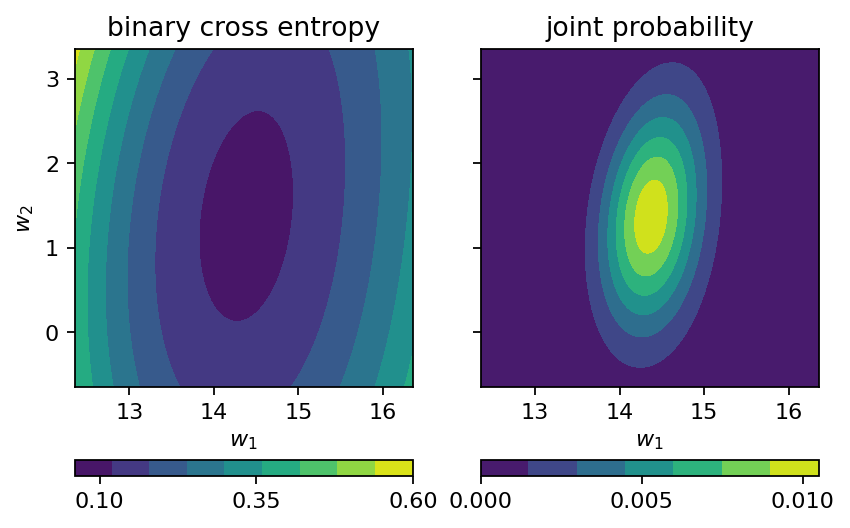

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

cont1 = ax1.contourf(w11, w22, entropy)
cont2 = ax2.contourf(w11, w22, joint_p)
cbar = plt.colorbar(cont1, ax=ax1, orientation="horizontal")
cbar.set_ticks([0.1, 0.35, 0.6])
cbar = plt.colorbar(cont2, ax=ax2, orientation="horizontal")
cbar.set_ticks([0.0, 0.005, 0.01])
for ax in (ax1, ax2):
    ax.set_xlabel(r"$w_1$")
    ax.set_aspect("equal")
ax1.set_ylabel(r"$w_2$")
ax1.set_title("binary cross entropy")
ax2.set_title("joint probability")
plt.savefig(f"{output}/entropy_loss_landscape.svg", bbox_inches="tight")

In [65]:
one_three = (logData.regime == "I") | (logData.regime == "III")
features_I_II = pt.tensor(logData[one_two][["Ga", "Eo"]].values).type(pt.float32)
features_I_III = pt.tensor(logData[one_three][["Ga", "Eo"]].values).type(pt.float32)
label_I_II = pt.tensor(logData.ordinal[one_two].values).type(pt.float32)
label_I_III = pt.tensor(logData.ordinal[one_three].values).type(pt.float32)
label_I_III.clamp_(0.0, 1.0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [66]:
model_I_II = LogisticRegression(3)
model_I_III = LogisticRegression(3)
_ = model_I_II.train(features_I_II, label_I_II)
_ = model_I_III.train(features_I_III, label_I_III)
print("Weights model I-II: ", model_I_II._p)
print("Weights model I-III: ", model_I_III._p)

Converged after 3022 epochs.
Converged after 891 epochs.
Weights model I-II:  tensor([ 14.3539,   1.3520, -21.3898])
Weights model I-III:  tensor([  1.7470,   6.6995, -10.4676])


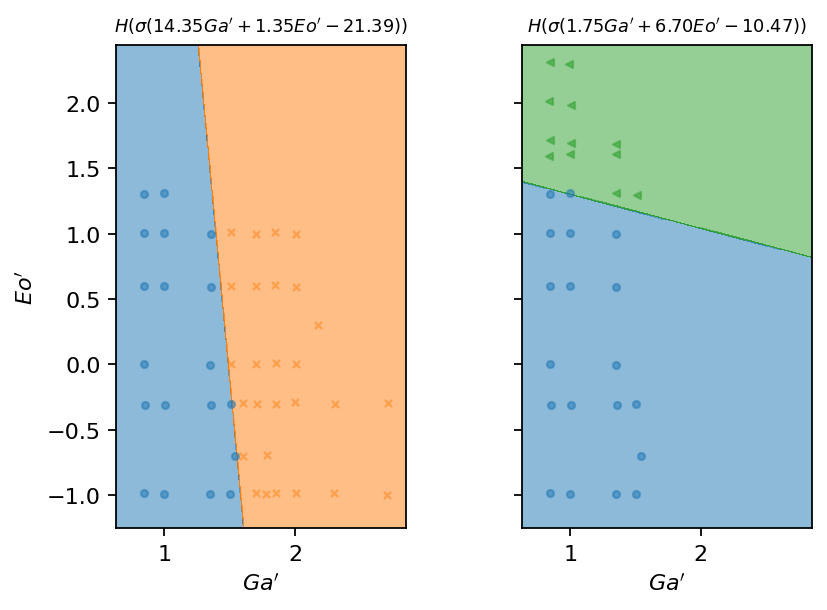

In [67]:
xx, yy = pt.meshgrid(
    pt.linspace(logData.Ga.min()*0.75, logData.Ga.max()*1.05, 500),
    pt.linspace(logData.Eo.min()*1.25, logData.Eo.max()*1.05, 500)
)
fig, axarr = plt.subplots(1, 2, sharex=True, sharey=True)

for i, model in enumerate((model_I_II, model_I_III)):
    prediction = model.predict(pt.stack((xx.flatten(), yy.flatten())).T)
    axarr[i].contourf(xx, yy, prediction.reshape(xx.shape), cmap=ListedColormap(["C0", f"C{i+1}"]), alpha=0.5)
    axarr[i].set_aspect("equal")
    axarr[i].set_xlabel(r"$Ga^\prime$")
    add_markers(axarr[i], (0, i+1))
axarr[0].set_ylabel(r"$Eo^\prime$")
axarr[0].set_title(r"$H(\sigma({:1.2f}Ga^\prime {:+1.2f}Eo^\prime {:+1.2f}))$".format(*model_I_II._p), fontsize=8)
axarr[1].set_title(r"$H(\sigma({:1.2f}Ga^\prime {:+1.2f}Eo^\prime {:+1.2f}))$".format(*model_I_III._p), fontsize=8)
plt.savefig(f"{output}/log_regression_I_II_II.svg", bbox_inches="tight")

In [68]:
combined_prob = pt.sigmoid(
    0.9*model_I_II.probability(pt.stack((xx.flatten(), yy.flatten())).T)
  + 0.9*model_I_III.probability(pt.stack((xx.flatten(), yy.flatten())).T)
  - 0.5
)
combined_prediction = pt.heaviside(combined_prob - 0.5, pt.tensor(0.0))

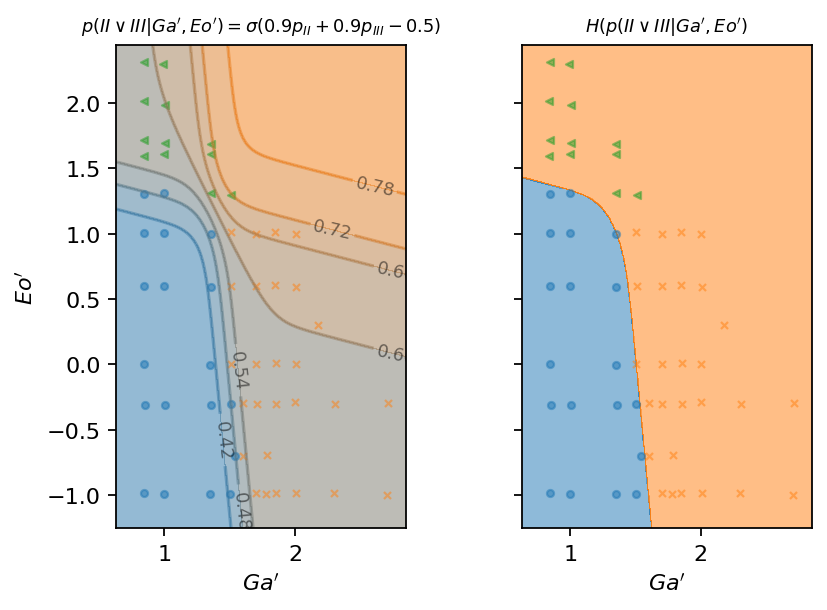

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

ax1.contourf(xx, yy, combined_prob.reshape(xx.shape), cmap=cm, alpha=0.5)
cont = ax1.contour(xx, yy, combined_prob.reshape(xx.shape), cmap=cm, alpha=0.5)
ax1.clabel(cont, fontsize=8, colors="k", fmt=lambda x: f"{x:2.2f}", inline_spacing=5,  zorder=6)
ax2.contourf(xx, yy, combined_prediction.reshape(xx.shape), cmap=ListedColormap(['C0', 'C1']), alpha=0.5)
for ax in (ax1, ax2):
    ax.set_aspect("equal")
    ax.set_xlabel(r"$Ga^\prime$")
    add_markers(ax, (0, 1, 2))
ax1.set_ylabel(r"$Eo^\prime$")
ax1.set_title(r"$p(II\vee III | Ga^\prime, Eo^\prime)=\sigma(0.9p_{II}+0.9p_{III}-0.5)$", fontsize=8)
ax2.set_title(r"$H(p(II\vee III | Ga^\prime, Eo^\prime)$", fontsize=8)
plt.savefig(f"{output}/log_combined_prob.svg", bbox_inches="tight")

## Extension to multiple classes

In [72]:
class NetworkClassifier(pt.nn.Module):
    """Neural network for classification.
    """
    def __init__(self, n_features=2, n_classes=5, n_neurons=60, activation=pt.sigmoid):
        super().__init__()
        self._activation = activation
        self._layer_1 = pt.nn.Linear(n_features, n_neurons)
        self._layer_2 = pt.nn.Linear(n_neurons, n_neurons)
        self._layer_3 = pt.nn.Linear(n_neurons, n_classes)
        
    def forward(self, x: pt.Tensor) -> pt.Tensor:
        x = self._activation(self._layer_1(x))
        x = self._activation(self._layer_2(x))
        return pt.nn.functional.log_softmax(self._layer_3(x), dim=1)

In [73]:
regime_model = NetworkClassifier()
# categorial cross entropy taking logarithmic probabilities
criterion = pt.nn.NLLLoss()
# stochastic gradient decent: ADAM
optimizer = pt.optim.Adam(regime_model.parameters(), lr=0.005)

In [74]:
epochs = 2000
losses = []

# convert feature and label arrays into PyTorch tensors
features = pt.tensor(logData[["Ga", "Eo"]].values, dtype=pt.float32)
labels = pt.tensor(logData.ordinal.values, dtype=pt.int64)

for e in range(1, epochs):
    optimizer.zero_grad()
    # run forward pass through the network
    log_prob = regime_model(features)
    # compute cross entropy
    loss = criterion(log_prob, labels)
    # compute gradient of the loss function w.r.t. to the model weights
    loss.backward()
    # update weights
    optimizer.step()
    # keep track and print progress
    losses.append(loss.item())
    print("\r", "Training loss epoch {:5d}: {:10.5e}".format(
            e, losses[-1]), end="")
    if losses[-1] < 5.0E-3:
        print(f"\nTraining converged after {e+1} epochs")
        break

 Training loss epoch  1795: 4.99178e-03
Training converged after 1796 epochs


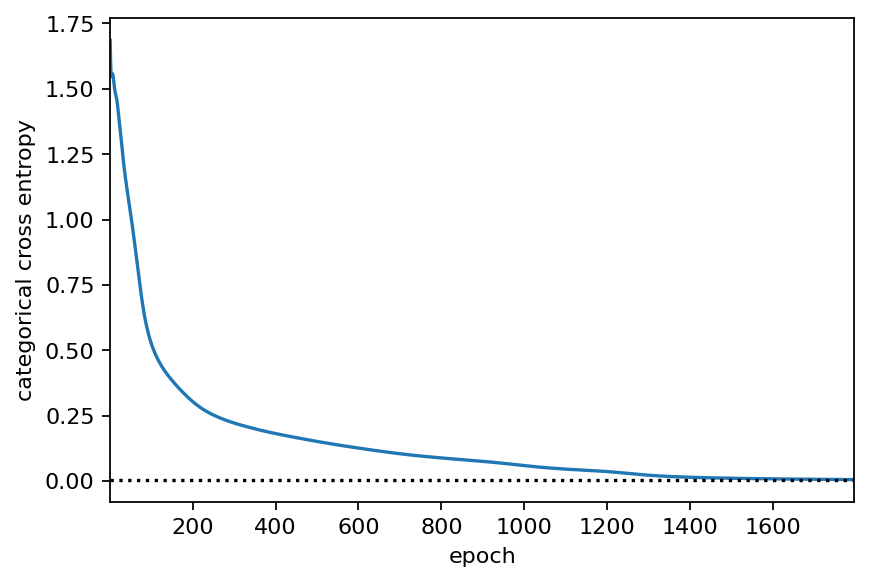

In [75]:
plt.plot(range(1, len(losses)+1), losses)
plt.xlabel("epoch")
plt.ylabel("categorical cross entropy")
plt.xlim(1.0, len(losses)+1)
plt.axhline(5.0e-3, 0.0, 1.0, ls=":", c="k")
plt.savefig(f"{output}/network_classification_loss.svg", bbox_inches="tight")

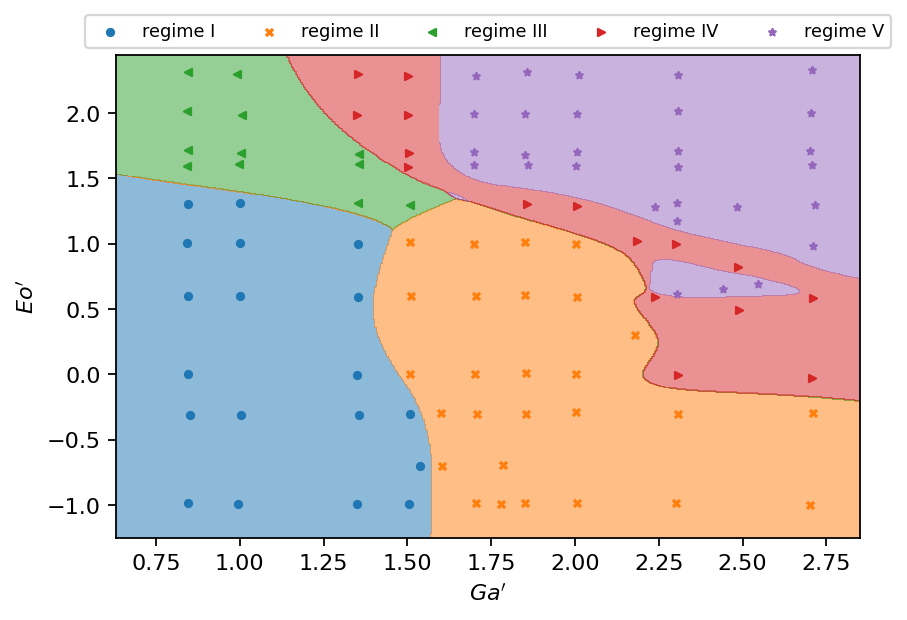

In [76]:
xx, yy = pt.meshgrid(
    pt.linspace(logData.Ga.min()*0.75, logData.Ga.max()*1.05, 500),
    pt.linspace(logData.Eo.min()*1.25, logData.Eo.max()*1.05, 500)
)
X = pt.stack((xx.flatten(), yy.flatten())).T
prob = regime_model(X).exp()
prediction = pt.argmax(prob, dim=1) + 0.01

fig, ax = plt.subplots()
cmap = ListedColormap([f"C{i}" for i in range(5)])
ax.contourf(xx, yy, prediction.reshape(xx.shape), cmap=cmap, alpha=0.5)
for regime, marker in zip(regimes, markers):
    ax.scatter(logData[logData["regime"] == regime].Ga, logData[logData["regime"] == regime].Eo,
               marker=marker, s=10, label="regime {}".format(regime))
ax.set_xlabel(r"$Ga^\prime$")
ax.set_ylabel(r"$Eo^\prime$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fontsize=8)
plt.savefig(f"{output}/network_multiclass_prediction.svg", bbox_inches="tight")